In [1]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import time
import pandas as pd
import plotly.graph_objects as goa
import warnings
from tbats import TBATS
import os
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

### Load raw data

In [2]:
dataFrame_daily = pd.read_table(r"./Data/DailyData_VolumeProfile.csv", sep = ";", engine = 'python')

In [3]:
dataFrame = pd.read_table(r"./Data/FDAXM22-EUREX_5Min.csv", sep = ";", engine = 'python')
for col in dataFrame.columns:
    if col[0] == " ":
        dataFrame = dataFrame.rename(columns={col : col[1:]})

In [4]:
len(dataFrame)

395981

### Normalizing data via week predictions - Exponential Smoothing

In [45]:
weekDays=["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]

date_df = dataFrame_daily['Date']
date = []
for d in date_df:
    year = int(d[-4:])
    day = int(d[:2])
    month = int(d[3:5])
    tmp = datetime.date(year, month, day)
    weekDay = weekDays[tmp.weekday()]
    date.append(weekDay)

In [48]:
dataFrame_daily['Jour'] = pd.Series(date)

In [58]:
week_days = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]

df_all_weeks = []
i = 0
while i < len(dataFrame):
    this_week = pd.DataFrame()

    if dataFrame.iloc[i].Jour == 'Lundi':
        today = dataFrame.iloc[i].Date
        j = i
        while j < len(dataFrame) and dataFrame.iloc[j].Date == today:
            #on recupere d'abord tous les 'lundi'
            j += 1
        for week_day in week_days:
            while j < len(dataFrame) and dataFrame.iloc[j].Jour == week_day:
                j+=1
        this_week = dataFrame.iloc[i:j]
        df_all_weeks.append(this_week)
        i = j
    else:
        i+=1

In [59]:
normalized_df_weeks = [df.copy(deep=True) for df in df_all_weeks]

In [60]:
def adapt_weeks(current_week, week_to_predict):
    if len(current_week) > len(week_to_predict):
        current_week = current_week.iloc[:len(week_to_predict)]
    else:
        while len(current_week) < len(week_to_predict):
            nb = 0
            week_days = np.unique(list(week_to_predict.Jour))
            times = np.unique(list(week_to_predict.Time))
            for week_day in week_days:
                for time in times:
                    if len(current_week.loc[(current_week.Jour == week_day) & (current_week.Time == time)]) == 0 and len(week_to_predict.loc[(week_to_predict.Jour == week_day) & (week_to_predict.Time == time)]) > 0:
                        new_value = week_to_predict.loc[(week_to_predict.Jour == week_day) & (week_to_predict.Time == time)]
                        if nb >= len(current_week) - 1:
                            new_value.Last = list(current_week.Last)[len(current_week)-2]
                        elif nb == 0:
                            new_value.Last = list(current_week.Last)[1]
                        else:
                            new_value.Last = (list(current_week.Last)[nb-1] + list(current_week.Last)[nb+1])/2
                        tmp = pd.concat([current_week.iloc[:nb], new_value])
                        tmp = pd.concat([tmp, current_week.iloc[nb:]])
                        current_week = tmp
                    else:
                        nb += 1
                        
    if len(current_week) > len(week_to_predict):
        current_week = current_week.iloc[:len(week_to_predict)]
        
    return current_week, week_to_predict

In [81]:
def normaliser_donnees(current_week, week_to_predict, donnee, list_predictions):
    
    if donnee == 'Last':
        dateFrame_colonne = current_week.Last
        toPredict_colonne = week_to_predict.Last
    elif donnee == 'Open':
        dateFrame_colonne = current_week.Open
        toPredict_colonne = week_to_predict.Open
    elif donnee == 'High':
        dateFrame_colonne = current_week.High
        toPredict_colonne = week_to_predict.High
    else:
        dateFrame_colonne = current_week.Low
        toPredict_colonne = week_to_predict.Low
    
    prediction = SimpleExpSmoothing(dateFrame_colonne, initialization_method="estimated").fit()
    #print("ceoff alpha -> ", prediction.model.params["smoothing_level"])
    predicted = list(prediction.fittedvalues)
    list_predictions.append(predicted)

    previous = list(toPredict_colonne)
    moyenne_previous = np.sum(previous)/len(previous)
    new = []
    for j in range(len(current_week)):
        new.append((previous[j]-predicted[j])/moyenne_previous)

    return new, prediction.model.params["smoothing_level"]

In [82]:
warnings.filterwarnings("ignore")
predicted_weeks = pd.DataFrame()
nb_weeks_predicted = 0
predictions_Open = []
predictions_Last = []
predictions_High = []
predictions_Low = []
alpha_High = []
alpha_Low = []
alpha_Last = []
alpha_Open = []

while nb_weeks_predicted < len(df_all_weeks) - 1:
    current_week = df_all_weeks[nb_weeks_predicted]
    week_to_predict = df_all_weeks[nb_weeks_predicted + 1]
    
    current_week, week_to_predict = adapt_weeks(current_week, week_to_predict)
    
    #on normalise le Last
    newLast, alpha = normaliser_donnees(current_week, week_to_predict, 'Last', predictions_Last)
    normalized_df_weeks[nb_weeks_predicted+1].Last = newLast
    alpha_Last.append(alpha)
    
    
    #on normalise le Open
    newOpen, alpha = normaliser_donnees(current_week, week_to_predict, 'Open', predictions_Open)
    normalized_df_weeks[nb_weeks_predicted+1].Open = newOpen
    alpha_Open.append(alpha)
    
    #on normalise le High
    newHigh, alpha = normaliser_donnees(current_week, week_to_predict, 'High', predictions_High)
    normalized_df_weeks[nb_weeks_predicted+1].High = newHigh
    alpha_High.append(alpha)
    
    #on normalise le Low
    newLow, alpha = normaliser_donnees(current_week, week_to_predict, 'Low', predictions_Low)
    normalized_df_weeks[nb_weeks_predicted+1].Low = newLow
    alpha_Low.append(alpha)
    
    nb_weeks_predicted += 1
    
print(np.mean(alpha_Open))
print(np.mean(alpha_Last))
print(np.mean(alpha_High))
print(np.mean(alpha_Last))

0.946223102706276
0.966178058705498
0.9745254132355358
0.966178058705498


In [65]:
norm_dataFrame = pd.DataFrame()
for i in range(1, len(normalized_df_weeks)):
    norm_dataFrame = pd.concat([norm_dataFrame, normalized_df_weeks[i]])

###### Normaliser les volumes

In [67]:
#moyenne_BidVol = np.sum(list(norm_dataFrame.BidVolume)) / len(norm_dataFrame.BidVolume)
#moyenne_AskVol = np.sum(list(norm_dataFrame.AskVolume)) / len(norm_dataFrame.AskVolume)
moyenne_Vol = np.sum(list(norm_dataFrame.Volume)) / len(norm_dataFrame.Volume)

In [68]:
#norm_dataFrame.BidVolume /= moyenne_BidVol
#norm_dataFrame.AskVolume /= moyenne_AskVol
norm_dataFrame.Volume /= moyenne_Vol

In [71]:
normAskVol = list(norm_dataFrame.AskVolume)
normBidVol = list(norm_dataFrame.BidVolume)

normDelta = [normAskVol[i] - normBidVol[i] for i in range(len(normBidVol))]

normCumulativeDelta = [normDelta[0]]
for i in range(1, len(normDelta)):
    nouvelle_valeur = normCumulativeDelta[-1] + normDelta[i]
    normCumulativeDelta.append(nouvelle_valeur)

In [ ]:
norm_dataFrame.Delta = normDelta
norm_dataFrame['Cumulative Delta'] = normCumulativeDelta

### Visualize normalized Data

<Mpf_Figure size 1200x1000 with 0 Axes>

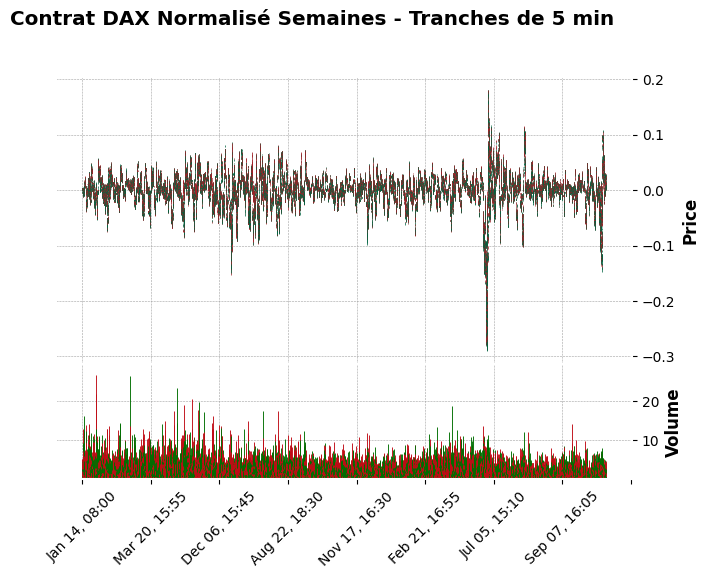

In [74]:
import mplfinance as mpf

plot_df = norm_dataFrame.copy(deep=True)

plot_df = plot_df.rename(columns={'Last': 'Close'})
plot_df.index = pd.DatetimeIndex(norm_dataFrame.Date + " " + norm_dataFrame.Time)

fig = mpf.figure(figsize=(12, 10))
mpf.plot(plot_df, type = 'ohlc', style = 'charles', title = 'Contrat DAX Normalisé Semaines - Tranches de 5 min', volume = True, warn_too_much_data = 388282+1)

<Mpf_Figure size 1200x1000 with 0 Axes>

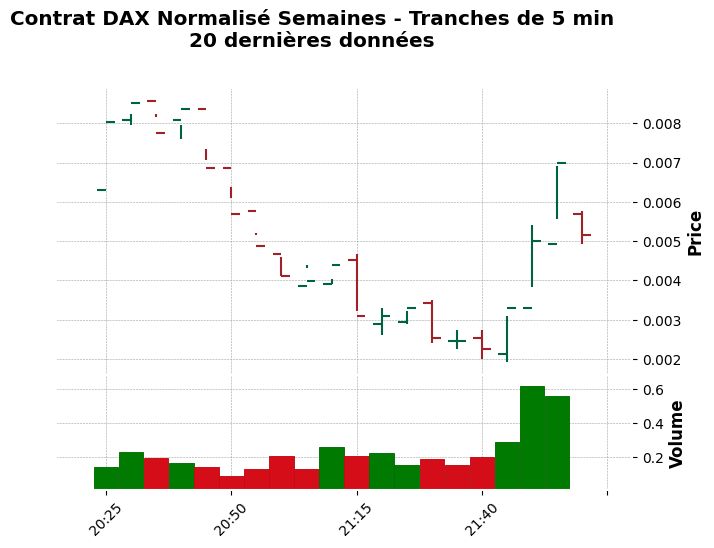

In [78]:
import mplfinance as mpf

plot_df = norm_dataFrame[-20:].copy(deep=True)

plot_df = plot_df.rename(columns={'Last': 'Close'})
plot_df.index = pd.DatetimeIndex(plot_df.Date + " " + plot_df.Time)

fig = mpf.figure(figsize=(12, 10))
mpf.plot(plot_df, type = 'ohlc', style = 'charles', title = 'Contrat DAX Normalisé Semaines - Tranches de 5 min\n20 dernières données', volume = True, warn_too_much_data = 388282+1)

## Normalisation sans prédiction

In [83]:
def get_df_weeks(dataFrame):
    try:
        dataFrame.Jour
    except:
        #la colonne 'Jour' n'existe pas, on la crée
        import datetime
        week_days = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]

        jours = []
        for i in range(len(dataFrame)):
            date = dataFrame.iloc[i].Date
            strjour, strmois, strannee = date.split("/")
            jour, mois, annee = int(strjour), int(strmois), int(strannee)
            jours.append(week_days[datetime.date(annee, mois, jour).weekday()])

        dataFrame.insert(loc=2, column='Jour', value=pd.Series(jours))

    for col in dataFrame.columns:
        if col[0] == " ":
            dataFrame = dataFrame.rename(columns={col: col[1:]})

    week_days = ["Lundi", "Mardi", "Mercredi", "Jeudi", "Vendredi", "Samedi", "Dimanche"]

    df_all_weeks = []
    i = 0
    while i < len(dataFrame):
        this_week = pd.DataFrame()

        if dataFrame.iloc[i].Jour == 'Lundi':
            today = dataFrame.iloc[i].Date
            j = i
            while j < len(dataFrame) and dataFrame.iloc[j].Date == today:
                #on recupere d'abord tous les 'lundi'
                j += 1
            for week_day in week_days:
                while j < len(dataFrame) and dataFrame.iloc[j].Jour == week_day:
                    j+=1
            this_week = dataFrame.iloc[i:j]
            df_all_weeks.append(this_week)
            i = j
        else:
            i+=1
    
    normalized_df_weeks = [df.copy(deep=True) for df in df_all_weeks]
    return df_all_weeks, normalized_df_weeks, dataFrame

In [84]:
df_all_weeks, normalized_df_weeks, dataFrame = get_df_weeks(dataFrame)

In [86]:
def moyenneSemaine(week):
    return np.mean(list(week.Last))
    
def moyenneMobileSemaine(num_semaine, profondeur):
    liste = []
    k = num_semaine
    
    while k >= 0 and len(liste) < profondeur:
        week = df_all_weeks[k]
        liste.append(moyenneSemaine(week))
        k -= 1
        
    return np.mean(liste)

In [87]:
def normaliser_donnees_sans_prediction(current_week_number, week_to_predict, donnee, profondeurMoyenneMobile):
    
    if donnee == 'Last':
        toNormalize_colonne = week_to_predict.Last
    elif donnee == 'Open':
        toNormalize_colonne = week_to_predict.Open
    elif donnee == 'High':
        toNormalize_colonne = week_to_predict.High
    else:
        toNormalize_colonne = week_to_predict.Low
        
    dateFrame_colonne = df_all_weeks[current_week_number].Last
    moyenne = moyenneMobileSemaine(current_week_number, profondeurMoyenneMobile)
    
    normalized = np.array(list(toNormalize_colonne))/moyenne

    return normalized

In [88]:
def normaliserSemaines(profondeur):
    warnings.filterwarnings("ignore")
    predicted_weeks = pd.DataFrame()
    nb_weeks_normalized = 0
    predictions_Open = []
    predictions_Last = []
    predictions_High = []
    predictions_Low = []

    while nb_weeks_normalized < len(df_all_weeks) - 1:
        current_week = nb_weeks_normalized
        week_to_predict = df_all_weeks[nb_weeks_normalized + 1]

        #on normalise le Last
        newLast = normaliser_donnees_sans_prediction(current_week, week_to_predict, 'Last', profondeur)
        normalized_df_weeks[nb_weeks_normalized+1].Last = newLast


        #on normalise le Open
        newOpen = normaliser_donnees_sans_prediction(current_week, week_to_predict, 'Open', profondeur)
        normalized_df_weeks[nb_weeks_normalized+1].Open = newOpen


        #on normalise le High
        newHigh = normaliser_donnees_sans_prediction(current_week, week_to_predict, 'High', profondeur)
        normalized_df_weeks[nb_weeks_normalized+1].High = newHigh


        #on normalise le Low
        newLow = normaliser_donnees_sans_prediction(current_week, week_to_predict, 'Low', profondeur)
        normalized_df_weeks[nb_weeks_normalized+1].Low = newLow


        nb_weeks_normalized += 1
        
    norm_dataFrame = pd.DataFrame()
    for i in range(1, len(normalized_df_weeks)):
        norm_dataFrame = pd.concat([norm_dataFrame, normalized_df_weeks[i]])
        
    return norm_dataFrame

In [89]:
def normaliserDataFrame(profondeur):
    norm_dataFrame = normaliserSemaines(profondeur)
    moyenne_BidVol = np.sum(list(norm_dataFrame['Bid Volume'])) / len(norm_dataFrame['Bid Volume'])
    moyenne_AskVol = np.sum(list(norm_dataFrame['Ask Volume'])) / len(norm_dataFrame['Ask Volume'])
    moyenne_Vol = np.sum(list(norm_dataFrame.Volume)) / len(norm_dataFrame.Volume)
    norm_dataFrame['Bid Volume'] /= moyenne_BidVol
    norm_dataFrame['Ask Volume'] /= moyenne_AskVol
    norm_dataFrame.Volume /= moyenne_Vol
    normAskVol = list(norm_dataFrame['Ask Volume'])
    normBidVol = list(norm_dataFrame['Bid Volume'])

    normDelta = [normAskVol[i] - normBidVol[i] for i in range(len(normBidVol))]

    normCumulativeDelta = [normDelta[0]]
    for i in range(1, len(normDelta)):
        nouvelle_valeur = normCumulativeDelta[-1] + normDelta[i]
        normCumulativeDelta.append(nouvelle_valeur)
        
    norm_dataFrame.Delta = normDelta
    norm_dataFrame['Cumulative Delta'] = normCumulativeDelta
    
    return norm_dataFrame

In [90]:
norm_dataFrame = normaliserSemaines(14)

<Mpf_Figure size 1200x1000 with 0 Axes>

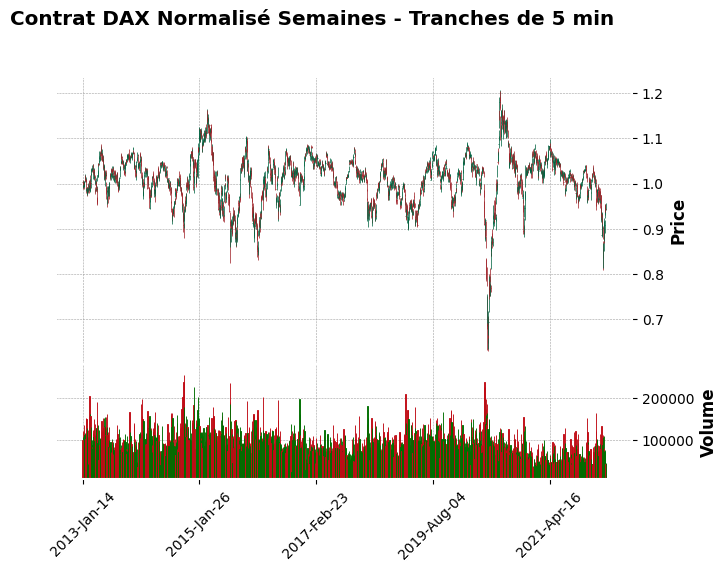

In [30]:
import mplfinance as mpf

plot_df = norm_dataFrame.copy(deep=True)

plot_df = plot_df.rename(columns={'Last': 'Close'})
plot_df.index = pd.DatetimeIndex(plot_df.Date)

fig = mpf.figure(figsize=(12, 10))
mpf.plot(plot_df, type = 'ohlc', style = 'charles', title = 'Contrat DAX Normalisé Semaines - Tranches de 5 min', volume = True, warn_too_much_data = 388282+1)

<Mpf_Figure size 1200x1000 with 0 Axes>

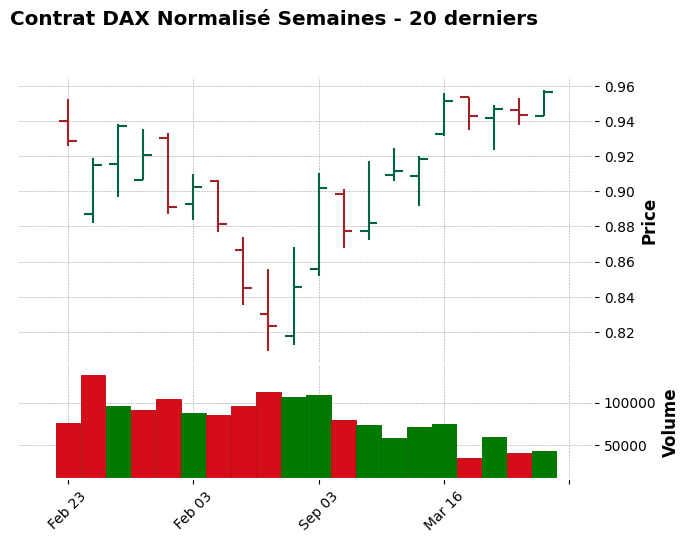

In [31]:
import mplfinance as mpf

plot_df = norm_dataFrame.copy(deep=True)[-20:]

plot_df = plot_df.rename(columns={'Last': 'Close'})
plot_df.index = pd.DatetimeIndex(plot_df.Date + " " + plot_df.Time)

fig = mpf.figure(figsize=(12, 10))
mpf.plot(plot_df, type = 'ohlc', style = 'charles', title = 'Contrat DAX Normalisé Semaines - 20 derniers', volume = True, warn_too_much_data = 388282+1)

In [51]:
days = list(dataFrame_daily['Date'])
norm_days = list(norm_dataFrame['Date'])

In [34]:
norm_dataFrame

,Date,Time,Jour,Open,High,Low,Last,Volume,# of Trades,OHLC Avg,...,VAL,VA_Spread,VA_EtatSpread,DailyHighToIBH,IBLToDailyLow,DailyHighToIBHNormalized,IBLToDailyLowNormalized,etatBarCloseToDailyCurrentVA',etatBarPOCToBar',IB_Sread_N
8,14/01/2013,08:00:00.0,Lundi,1.002623,1.008537,0.997480,1.001594,99267,42874,7797,...,7767,46,1,41.0,30.5,0.53,0.39,2,0,0.179718
9,15/01/2013,08:00:00.0,Mardi,0.999409,1.001851,0.988737,0.996580,120682,52207,7751,...,7721,69,2,14.0,68.0,0.18,0.88,2,1,0.264482
10,16/01/2013,08:00:00.0,Mercredi,0.993623,0.996708,0.989894,0.994523,96005,41328,7728,...,7701,29,0,17.5,10.0,0.23,0.13,2,-1,0.329670
11,17/01/2013,08:00:00.0,Jeudi,0.993751,1.005709,0.992337,1.000694,107667,45708,7763,...,7718,73,2,87.0,9.0,1.12,0.12,2,-1,0.109212
12,18/01/2013,08:00:00.0,Vendredi,1.002494,1.004166,0.997737,1.000694,100062,43747,7787,...,7768,22,-1,0.0,29.0,0.00,0.37,2,0,0.269819
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2328,16/03/2022,08:00:00.0,Mercredi,0.932816,0.955847,0.931246,0.951136,75354,67982,14409,...,14251,203,-1,257.0,18.0,1.77,0.12,2,-1,0.694779
2329,17/03/2022,08:00:00.0,Jeudi,0.953492,0.953950,0.935106,0.942696,34768,31804,14463,...,14364,188,-1,0.0,165.0,0.00,1.15,2,0,0.853692
2330,18/03/2022,08:00:00.0,Vendredi,0.941976,0.949304,0.923656,0.947014,60048,53341,14374,...,14218,183,-1,99.0,222.0,0.68,1.53,2,0,0.490535
2331,21/03/2022,08:00:00.0,Lundi,0.945996,0.953373,0.937763,0.943361,40985,37181,14350,...,14345,99,-2,75.0,96.0,0.52,0.67,2,1,0.460797


In [33]:
norm_dataFrame.to_csv(r"./Data/dataNormalisee_daily(14).csv", sep = ';', index=False)

### Reverse normalisation

In [91]:
def chercher_semaine_donnees_brutes(date, time):
    if time == 'Semaine':
        time = ' 08:00:00.0'
    day, month, year = date.split("/")
    
    for nb_week in range(len(df_all_weeks)):
        df = df_all_weeks[nb_week]
        firstDate = df.iloc[0].Date
        lastDate = df.iloc[len(df)-1].Date
        #print("fD " + firstDate + ", lD " + lastDate)
        if firstDate.split("/")[2] == year or lastDate.split("/")[2] == year:
            #if not then we keep going with the next week
            # we do so, so as to greatly reduce the amount of dataframes to look into to find the right one
            i = 0
            while i < len(df) and not (df.iloc[i].Date == date and df.iloc[i].Time == time):
                i += 1
            if i < len(df):
                #we have found the right week
                return nb_week, i
                
    return -1, -1 #no matching result has been found

In [103]:
def reverseNormalizationColumn(df, df_normalise, date, time, donnee, profondeur):
    
    nb_week, iloc = chercher_semaine_donnees_brutes(date, time)
    nb_week -= 1 #using week n to normalize the week intersting us, week n+1
    if (nb_week < 0):
        return -1
    else:
        df_norm = df_normalise.copy(deep=True)
        if time == 'Semaine': #goal is to create a fake 'Time' column for daily dataFrames, where such column isn't present
            time = ' 08:00:00.0'
        
        current_week = df_all_weeks[nb_week]
        our_week = df_all_weeks[nb_week+1]
        
        coeff = moyenneMobileSemaine(nb_week, profondeur)

        if donnee == 'Last':
            normValue = list(df_norm.loc[(df_norm.Date == date) & (df_norm.Time == time)].Last)[0]
        elif donnee == 'Open':
            normValue = list(df_norm.loc[(df_norm.Date == date) & (df_norm.Time == time)].Open)[0]
        elif donnee == 'High':
            normValue = list(df_norm.loc[(df_norm.Date == date) & (df_norm.Time == time)].High)[0]
        else:
            normValue = list(df_norm.loc[(df_norm.Date == date) & (df_norm.Time == time)].Low)[0]  
        
        unNormalizedValue = coeff*normValue
        return unNormalizedValue

In [61]:
def reverseNormalization(dataFrame_donnees_brutes, dataFrame_normalise, date, time, profondeur):
    reverseNormOpen = reverseNormalizationColumn(dataFrame_donnees_brutes, dataFrame_normalise, date, time, 'Open', profondeur)
    reverseNormHigh = reverseNormalizationColumn(dataFrame_donnees_brutes, dataFrame_normalise, date, time, 'High', profondeur)
    reverseNormLow = reverseNormalizationColumn(dataFrame_donnees_brutes, dataFrame_normalise, date, time, 'Low', profondeur)
    reverseNormLast = reverseNormalizationColumn(dataFrame_donnees_brutes, dataFrame_normalise, date, time, 'Last', profondeur)
    
    return round(reverseNormOpen, 0), round(reverseNormHigh, 0), round(reverseNormLow, 0), round(reverseNormLast, 0)

## Reformer les données brutes

In [ ]:
dates = []
times = []
opens = []
highs = []
lows = []
lasts = []

for i in range(1352, len(dataFrame)):
    tmp_df = dataFrame.iloc[i]
    date = tmp_df.Date
    time = tmp_df.Time
    open_, high, low, last = reverseNormalization(dataFrame, norm_dataFrame, date, time)
    dates.append(date)
    times.append(time)
    opens.append(open_)
    highs.append(high)
    lows.append(low)
    lasts.append(last)

In [ ]:
df_reversedNorm = pd.DataFrame()
df_reversedNorm.insert(loc=0, column='Date', value=pd.Series(dates))
df_reversedNorm.insert(loc=1, column='Jour', value=pd.Series(times))
df_reversedNorm.insert(loc=2, column='Open', value=pd.Series(opens))
df_reversedNorm.insert(loc=3, column='High', value=pd.Series(highs))
df_reversedNorm.insert(loc=4, column='Low', value=pd.Series(lows))
df_reversedNorm.insert(loc=5, column='Close', value=pd.Series(lasts))

In [ ]:
df_reversed = reversedNorm.loc[reversedNorm.High != -1]

In [ ]:
df_reversed

In [ ]:
import mplfinance as mpf

plot_df = df_reversed.copy(deep=True)

plot_df = plot_df.rename(columns={'Last': 'Close'})
plot_df.index = pd.DatetimeIndex(plot_df.Date + " " + plot_df.Time)

fig = mpf.figure(figsize=(12, 10))
mpf.plot(plot_df, type = 'ohlc', style = 'charles', title = 'Normalisation inversée', volume = True, warn_too_much_data = 388282+1)

### Reformer les données journalières 

In [100]:
dataFrame_daily = dataFrame
dataFrame_norm_daily = pd.read_table("Data/dataNormalisee.csv", sep = ";", engine = 'python')

In [109]:
def reverseDaily(dataFrame_daily, dataFrame_norm_daily, profondeur):    
    dates = []
    opens = []
    highs = []
    lows = []
    lasts = []

    for i in range(len(dataFrame_norm_daily)):
        if i%100==0: print(i)
        tmp_df = dataFrame_norm_daily.iloc[i]
        date = tmp_df.Date
        open_, high, low, last = reverseNormalization(dataFrame_daily, dataFrame_norm_daily, date, 'Semaine', profondeur)
        dates.append(date)
        opens.append(open_)
        highs.append(high)
        lows.append(low)
        lasts.append(last)
        
    df_reversedNorm_day = pd.DataFrame()
    df_reversedNorm_day.insert(loc=0, column='Date', value=pd.Series(dates))
    df_reversedNorm_day.insert(loc=1, column='Open', value=pd.Series(opens))
    df_reversedNorm_day.insert(loc=2, column='High', value=pd.Series(highs))
    df_reversedNorm_day.insert(loc=3, column='Low', value=pd.Series(lows))
    df_reversedNorm_day.insert(loc=4, column='Last', value=pd.Series(lasts))
        
    df_reversed_day = df_reversedNorm_day.loc[df_reversedNorm_day.High != -1]
    return df_reversed_day

In [110]:
df_reversed_day = reverseDaily(dataFrame_daily, dataFrame_norm_daily, 30)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200


## Reformer les données Initial Balance

In [60]:
dataFrame_IB = pd.read_table("Data/FDAXH22-matinal.txt", sep = ",", engine = 'python')
dataFrame_norm_IB = pd.read_table("Data/dataNormaliseeSansExp-IB.csv", sep = ";", engine = 'python')

In [53]:
def reverseInitialBalance(dataFrame_IB, dataFrame_norm_IB, profondeur):    
    dates = []
    opens = []
    highs = []
    lows = []
    lasts = []
    
    df_norm_IB = dataFrame_norm_IB.copy(deep=True)
    df_norm_IB = df_norm_IB.rename(columns={'Open Matinal': 'Open'})
    df_norm_IB = df_norm_IB.rename(columns={'High Matinal': 'High'})
    df_norm_IB = df_norm_IB.rename(columns={'Low Matinal': 'Low'})
    df_norm_IB = df_norm_IB.rename(columns={'Last Matinal': 'Last'})
    
    for i in range(len(dataFrame_norm_IB)):
        tmp_df = df_norm_IB.iloc[i]
        date = tmp_df.Date
        open_, high, low, last = reverseNormalization(dataFrame_IB, df_norm_IB, date, 'Semaine', 1)
        dates.append(date)
        opens.append(open_)
        highs.append(high)
        lows.append(low)
        lasts.append(last)
        
    df_reversedNorm_day = pd.DataFrame()
    df_reversedNorm_day.insert(loc=0, column='Date', value=pd.Series(dates))
    df_reversedNorm_day.insert(loc=1, column='Open', value=pd.Series(opens))
    df_reversedNorm_day.insert(loc=2, column='High', value=pd.Series(highs))
    df_reversedNorm_day.insert(loc=3, column='Low', value=pd.Series(lows))
    df_reversedNorm_day.insert(loc=4, column='Close', value=pd.Series(lasts))
        
    df_reversed_day = df_reversedNorm_day.loc[df_reversedNorm_day.High != -1]
    return df_reversed_day

In [54]:
df_reversed_IB = reverseInitialBalance(dataFrame_IB, dataFrame_norm_IB, 1)